
Congrats....again! Based off the amazing work you did on the classification model, you've been promoted to chief of all data scientists in Hollywood, your a total celebrity....among data scientists :).  

Your boss, head of the studio, has now asked you to build a model to predict gross revenue in order to help them decide which movies to invest in.

Once again, you would like to be able to explain the model to mere mortals but need a fairly robust and flexible approach so you've chosen to use decision trees to get started. 

In doing so...you leverage work you've done in the past to get the job done....you're a data scientist after all! 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz 

from sklearn.model_selection import train_test_split,RepeatedKFold,GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor, export_graphviz 
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [7]:
#1. Load the data
#Sometimes need to set the working directory back out of a folder that we create a file in


movie_metadata2 = pd.read_csv("/Users/Luke/DS-3001/data/movie_metadata.csv")
movie_metadata=pd.read_csv("/Users/Luke/DS-3001/data/movie_metadata.csv")
movie_metadata.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

#2 Ensure all the variables are classified correctly including the target variable and collapse factor variables as needed.

In [8]:
movie_metadata['content_rating'].value_counts()
movie_metadata["content_rating"]= movie_metadata["content_rating"].replace(
    ['R','PG-13','PG','Not Rated', 'G', 'Unrated', 'Approved', 'TV-14', 'TV-MA', 'TV-PG', 'X', 'TV-G', 'Passed', 'NC-17', 'GP', 'M', 'TV-Y', 'TV-Y7'], 
    ['Adult','Teen','Family','Adult','Family','Adult','Family','Teen','Adult','Family','Adult','Family','Family','Adult','Family','Adult','Family','Family']
)
movie_metadata['content_rating'].value_counts()

content_rating
Adult     2341
Teen      1491
Family     908
Name: count, dtype: int64

In [9]:
drop_cols = ['director_name', 'actor_2_name', 'genres',
             'actor_1_name', 'movie_title', 'actor_3_name',
             'plot_keywords', 'movie_imdb_link']
movie_metadata = movie_metadata.drop(drop_cols, axis=1)
movie_metadata.loc[movie_metadata['color'] != 'Color', 'color'] = 'Black and White'
movie_metadata[["color"]] = OrdinalEncoder().fit_transform(movie_metadata[["color"]])
movie_metadata.loc[movie_metadata['language'] != 'English', 'language'] = 'non-English'
movie_metadata[["language"]] = OrdinalEncoder().fit_transform(movie_metadata[["language"]])
movie_metadata.loc[movie_metadata['country'] != 'USA', 'country'] = 'foreign'
movie_metadata[["country"]] = OrdinalEncoder().fit_transform(movie_metadata[["country"]])
movie_metadata["content_rating"]= movie_metadata["content_rating"].replace(
    ['R','PG-13','PG','Not Rated', 'G', 'Unrated', 'Approved', 'TV-14', 'TV-MA', 'TV-PG', 'X', 'TV-G', 'Passed', 'NC-17', 'GP', 'M', 'TV-Y', 'TV-Y7'], 
    ['Adult','Teen','Family','Adult','Family','Adult','Family','Teen','Adult','Family','Adult','Family','Family','Adult','Family','Adult','Family','Family']
)
movie_metadata[["content_rating"]] = OrdinalEncoder().fit_transform(movie_metadata[["content_rating"]])
movie_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5043 non-null   float64
 1   num_critic_for_reviews     4993 non-null   float64
 2   duration                   5028 non-null   float64
 3   director_facebook_likes    4939 non-null   float64
 4   actor_3_facebook_likes     5020 non-null   float64
 5   actor_1_facebook_likes     5036 non-null   float64
 6   gross                      4159 non-null   float64
 7   num_voted_users            5043 non-null   int64  
 8   cast_total_facebook_likes  5043 non-null   int64  
 9   facenumber_in_poster       5030 non-null   float64
 10  num_user_for_reviews       5022 non-null   float64
 11  language                   5043 non-null   float64
 12  country                    5043 non-null   float64
 13  content_rating             4740 non-null   float

#3 Check for missing variables and correct as needed.

In [10]:
movie_metadata1=movie_metadata.dropna()

#4 Guess what, you don't need to scale the data, because DTs don't require this to be done, they make local greedy decisions...keeps getting easier, go to the next step.

#5 Determine the range and variance of the target variable.

In [11]:
revenue_range = max(movie_metadata1['gross']) - min(movie_metadata1['gross'])
variance = np.var(movie_metadata1['gross'])

In [12]:
X= movie_metadata1.drop(columns='gross')
y= movie_metadata1.gross

#6 Split your data into test, tune, and train. (80/10/10)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=21)
X_tune, X_test, y_tune, y_test = train_test_split(X_test,y_test,  train_size = 0.50,random_state=49)

#7 Create the kfold object for cross validation.

In [14]:
kf =RepeatedKFold(n_splits=10,n_repeats =5, random_state=30)

In [15]:
param={
    "max_depth" : [1,2,3,4],
    #"splitter":["best","random"],
    #"min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
    #"min_weight_fraction_leaf":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    #"max_features":["auto","log2","sqrt",None],
    #"max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] 
    #'min_impurity_decrease':[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01],
    #'ccp_alpha':[.001,.01,.1]
        }

#8 Create the scoring metric (several measures) you will use to evaluate your model and the max depth hyperparameter.

In [16]:
scoring= ['neg_mean_squared_error','r2','neg_mean_absolute_error']

#9 Build the regression tree object. 

In [17]:
#Regressor model we will use
reg=DecisionTreeRegressor(random_state=30)


#10 Use the kfold object and the scoring metric to find the best hyperparameter value for max depth via the grid search method.

In [18]:
#Set up search for best decisiontreeregressor estimator based on r-sqaured and all the different folds...
search = GridSearchCV(reg, param, scoring=scoring, n_jobs=-1, cv=kf,refit='r2')


#11 Fit the model to the training data.

In [19]:
#execute search on our trianing data
model = search.fit(X_train, y_train)

#12 What is the best depth value?

In [20]:
best= model.best_estimator_
print(best)

DecisionTreeRegressor(max_depth=4, random_state=30)


#13 View the results, comment on how the model performed using several evaluation metrics.

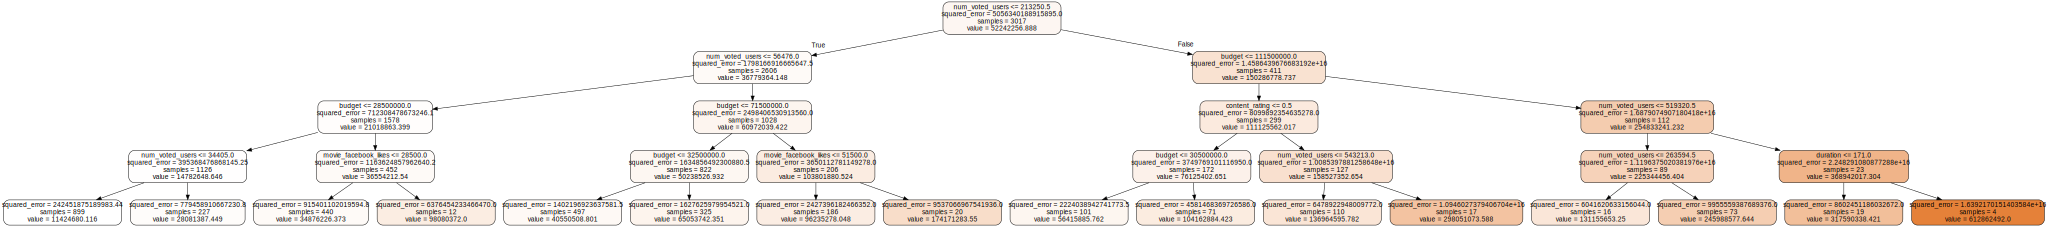

In [21]:
dot_data = export_graphviz(best, out_file =None,
               feature_names =X.columns, #feature names from dataset
               filled=True, 
                rounded=True, ) 
               
graph=graphviz.Source(dot_data)
graph

In [22]:
print(model.cv_results_)
print(model.cv_results_.keys())

{'mean_fit_time': array([0.01057415, 0.01304264, 0.02240942, 0.02487043]), 'std_fit_time': array([0.00353575, 0.00124545, 0.00635228, 0.00445617]), 'mean_score_time': array([0.00553664, 0.00445398, 0.00605618, 0.00540386]), 'std_score_time': array([0.00226214, 0.0007785 , 0.00378594, 0.00196495]), 'param_max_depth': masked_array(data=[1, 2, 3, 4],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 1}, {'max_depth': 2}, {'max_depth': 3}, {'max_depth': 4}], 'split0_test_neg_mean_squared_error': array([-2.58189564e+15, -2.23847175e+15, -2.04104035e+15, -2.26128120e+15]), 'split1_test_neg_mean_squared_error': array([-2.74955733e+15, -2.43431436e+15, -2.07532080e+15, -1.84611388e+15]), 'split2_test_neg_mean_squared_error': array([-3.91255890e+15, -2.84794147e+15, -2.26359534e+15, -2.26373547e+15]), 'split3_test_neg_mean_squared_error': array([-3.25256676e+15, -2.53832929e+15, -2.14131110e+15, -2.21249808e+15]), 'split4_

In [23]:
#Let's extract these scores based on depth!

#Scores: 

#Have negative mean squared error so need to take absolute value and square root to convert to root mean squared error
mean_sq_err = np.sqrt(abs(model.cv_results_['mean_test_neg_mean_squared_error']))
#nothing needs to be done for r2, it is the same
r2= model.cv_results_['mean_test_r2']
#Have negative mean absolute error so need to take absolute value
mae= abs(model.cv_results_['mean_test_neg_mean_absolute_error'])

#Get standard deviations as well...
SDmse =  model.cv_results_['std_test_neg_mean_squared_error']
SDr2= model.cv_results_['std_test_r2']
SDmae= model.cv_results_['std_test_neg_mean_absolute_error']

#Parameter:
depth= np.unique(model.cv_results_['param_max_depth']).data

#Build DataFrame:
final_model = pd.DataFrame(list(zip(depth, mean_sq_err, r2,mae, SDmse,SDr2,SDmae)),
               columns =['depth','rmse','r2','mae',"rmseSD",'r2SD','maeSD'])

#Let's take a look
final_model


,depth,rmse,r2,mae,rmseSD,r2SD,maeSD
0,1,6.014785e+07,0.278619,3.952670e+07,6.731380e+14,0.079490,2.321644e+06
1,2,5.350682e+07,0.426288,3.400341e+07,4.797930e+14,0.072602,1.910046e+06
2,3,4.957163e+07,0.507367,3.064571e+07,4.511063e+14,0.071740,1.865415e+06
3,4,4.759845e+07,0.547962,2.927472e+07,5.198757e+14,0.075591,1.896075e+06


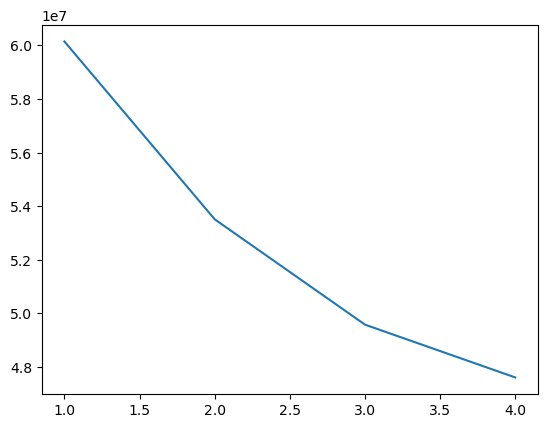

In [24]:
print(plt.plot(final_model.depth, final_model.rmse))

#14 Which variables appear to be contributing the most (variable importance) 

In [25]:
varimp=pd.DataFrame(best.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

                           importance
num_voted_users              0.654230
budget                       0.251829
content_rating               0.049549
duration                     0.028776
movie_facebook_likes         0.015617
country                      0.000000
aspect_ratio                 0.000000
imdb_score                   0.000000
actor_2_facebook_likes       0.000000
title_year                   0.000000
color                        0.000000
language                     0.000000
num_critic_for_reviews       0.000000
facenumber_in_poster         0.000000
cast_total_facebook_likes    0.000000
actor_1_facebook_likes       0.000000
actor_3_facebook_likes       0.000000
director_facebook_likes      0.000000
num_user_for_reviews         0.000000


#15 Create a model object using the best model hyperparameter value from the trained regression tree. 

In [26]:
best.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=4, random_state=30)

#16 Using the best model predict on the test data and print out the results.

In [27]:
pred=best.predict(X_test)
print(pred[:10])

[1.14246801e+07 4.05505088e+07 1.14246801e+07 1.36964596e+08
 6.50537424e+07 4.05505088e+07 1.36964596e+08 1.36964596e+08
 2.45988578e+08 3.48762264e+07]


#17 How does the model perform on the test data as compared to the training data?

In [28]:
print(best.score(X_test, y_test))
print(best.score(X_train, y_train))

0.6364013256035417
0.6562816568130538


In [29]:
print(metrics.r2_score(y_test, pred))



0.6364013256035417


In [30]:
# Assuming you have fitted the model on the training data and predicted on the test data
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Calculate metrics on the training data
train_rmse = np.sqrt(mean_squared_error(y_train, best.predict(X_train)))
train_r2 = metrics.r2_score(y_train, best.predict(X_train))
train_mae = mean_absolute_error(y_train, best.predict(X_train))

# Calculate metrics on the test data
test_rmse = np.sqrt(mean_squared_error(y_test, pred))
test_r2 = metrics.r2_score(y_test, pred)
test_mae = mean_absolute_error(y_test, pred)

# Compare the metrics
print("Training RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Training R-squared (R2):", train_r2)
print("Test R-squared (R2):", test_r2)
print("Training MAE:", train_mae)
print("Test MAE:", test_mae)




Training RMSE: 41688809.91733551
Test RMSE: 38488122.557785444
Training R-squared (R2): 0.6562816568130538
Test R-squared (R2): 0.6364013256035417
Training MAE: 27163146.343904853
Test MAE: 26889986.37660065


#18 What five movies are predicted to have the lowest gross revenue from the test set? 

In [63]:
y_pred = best.predict(X_test)
test_data = X_test.copy()
test_data['predicted_gross'] = y_pred
top_5_movies = test_data.sort_values(by='predicted_gross', ascending=True).head(5)
top_5_movies['gross']= y_test.loc[top_5_movies.index].values
top_5_movies['title'] = movie_metadata2.loc[top_5_movies.index, 'movie_title'].values
top_5_movies

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,predicted_gross,gross,title
1912,0.0,38.0,85.0,0.0,503.0,1000.0,12218,2908,0.0,33.0,...,1.0,25000000.0,2002.0,535.0,5.2,2.35,187,1.142468e+07,39880476.0,The Wild Thornberrys Movie
1995,0.0,60.0,104.0,54.0,919.0,6000.0,24790,9662,0.0,173.0,...,0.0,25000000.0,1995.0,923.0,5.2,2.35,0,1.142468e+07,4064333.0,Tank Girl
4240,0.0,67.0,89.0,16.0,14.0,117.0,12244,155,0.0,95.0,...,0.0,15500000.0,2001.0,21.0,7.6,1.85,0,1.142468e+07,313436.0,Elling
4725,0.0,5.0,86.0,24.0,142.0,407.0,3411,1090,0.0,36.0,...,1.0,500000.0,1974.0,189.0,6.1,1.85,816,1.142468e+07,39552600.0,Benji
2773,0.0,86.0,109.0,41.0,748.0,997.0,19505,3544,0.0,162.0,...,2.0,14000000.0,2007.0,826.0,5.2,2.35,0,1.142468e+07,61356221.0,Stomp the Yard


#19 Summarize what you learned along the way and make recommendations on how this could be used moving forward, being careful not to over promise.